In [45]:
import json
import pandas as pd
import pickle
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
from itertools import chain
from IPython.display import display, HTML
from nlp.utils import plot_histogram

# Load items and groups 

In [138]:
with open("../data/output/druid_fasttext/tok+freq_groups_top5_20.json") as f:
    groups_ = json.load(f)

with open("../data/output/druid_fasttext/results.pkl", "rb") as f:
    groups_items = pickle.load(f)

In [66]:
strategy = "Termos + frequentes [top10, 70%]"
# strategy = "Descrição + frequente"

In [4]:
groups_df = pd.read_csv('../data/output/druid_fasttext/clusters.csv.zip', sep=';')

In [5]:
df = pd.read_csv("../data/output/druid_fasttext/f03_items.csv.zip", sep=";") # itens licitação

In [6]:
# Adiciona a informação de grupo e ruído no dataframe de itens
df = df.merge(groups_df, left_on='item_id', right_on='item_id')

In [7]:
# Exclui grupos de ruídos e grupos não particionados
df = df[df.item_ruido == 0]
df['original_desc'] = df['original_prep'].apply(lambda x: ' '.join(eval(x)))

In [11]:
df.set_index('item_id', inplace=True)

In [9]:
unidades_medidas = df.unidades_medida.drop_duplicates().apply(lambda v:eval(v))
unidades_medidas = list(chain.from_iterable(unidades_medidas.values))
print(", ".join(unidades_medidas[:15]) + " [...]")

mg, ml, cm, litro, mm, mg, ml, lt, kg, mes, ml, ano, ampere, rpm, mm [...]


# Top 20 canonical descriptions

In [115]:
def get_description_and_n_items(groups, groups_items, n=20):
    group_n_itens = []
    descriptions = []
    for group in groups:
        items = df.loc[groups_items[group]]["original_desc"].to_list()
        group_n_itens.append(f"{group} ({len(items)})")
        descriptions.extend(items)
        
    description_count = Counter(descriptions)
    top_n_descriptions = []
    total = sum(description_count.values())
    for description, count in description_count.most_common(n):
        top_n_descriptions.append(f"{description} ({100 * count/total:>6.2f}%)")
        
    return group_n_itens, top_n_descriptions


def get_units_of_measure(groups, groups_items):
    units_of_measure = []
    for group in groups:
        units_of_measure_by_group = df.loc[groups_items[group]].unidades_medida.apply(lambda v: eval(v))
        units_of_measure_by_group = list(chain.from_iterable(units_of_measure_by_group.values))
        units_of_measure.extend(units_of_measure_by_group)
            
    return list(set(units_of_measure))

def get_numbers(groups, groups_items):
    numbers = []
    pattern = re.compile("^[0-9]+$")
    for group in groups:
        numbers_by_group = df.loc[groups_items[group]]["original_prep"].apply(lambda v: [str(e) for e in eval(v) if pattern.match(e)])
        numbers_by_group = list(chain.from_iterable(numbers_by_group.values))
        numbers.extend(numbers_by_group)
            
    return list(set(numbers))


def fmt(string, n):
    if len(string) > n:
        return "\"" + string[:n-3] + "..." + "\""
    else:
        return "\"" + string + "\""

# Is it a number or a unit of measure?
def contains_number_and_unit_of_measure(canonical_description):
    tokens = canonical_description.split()
    contains_number, contains_unit_of_measure = False, False
    pattern = re.compile("[0-9]+")
    for token in tokens:
        if pattern.match(token):
            contains_number = True
        if token in unidades_medidas:
            contains_unit_of_measure = True
            
    return contains_number and contains_unit_of_measure

def plot_hist(data: Counter, *, xlabel, filename, persist=True):
    _df = pd.DataFrame(data.items())
    sns.barplot(data=_df, x=0, y=1, color="blue")
    plt.xlabel(xlabel)
    plt.ylabel("# ocorrências")
    plt.xticks(fontsize=10)
    plt.xticks(fontsize=8, rotation=90)
    if persist:
        plt.savefig(filename, dpi=300)
    display(plt.show())

## All groups

In [29]:
html_str = "<table>"
html_str += "<td>Estratégia</td><td>Novo Grupo</td><td>Grupos originais</td><td># Grupos originais</td><td>Descrição canônica</td><td>Descrições frequentes</td>"

groups = list(groups_.items())
groups.sort(key=lambda group: len(group[1]["groups"]), reverse=True)    
for g in groups[:10]:
    new_group = g[0]
    canonical_description = g[1]["description"]
    previous_groups = g[1]["groups"]
    previous_groups_with_n_items, frequent_descriptions = get_description_and_n_items(previous_groups, groups_items)
    previous_groups_str = ", ".join(previous_groups_with_n_items)
    top_n_frequent_descriptions = "\n".join([fmt(x, 70).lower() for x in frequent_descriptions])

    html_str += "<tr>"
    html_str += f"<td>{strategy}</td>"
    html_str += f"<td>{new_group}</td><td>{previous_groups_str}</td><td>{len(previous_groups)}</td><td>{canonical_description}</td><td>{top_n_frequent_descriptions}</td>"
    html_str += "</tr>"
        
html_str += "</table>"
display(HTML(html_str))

"Termos + frequentes [top5, 20%]",outro_0_10_11_12_3_5_6_9,"outro_0 (59), outro_10 (280), outro_11 (70), outro_12 (297), outro_3 (38), outro_5 (137), outro_6 (34), outro_9 (38)",8,juridico outro pessoa servico terceiro,"""outro servico terceiro pessoa juridico ( 9.86%)"" ""outro servico terceiro pessoa juridico grafico ( 5.77%)"" ""outro servico terceiro pessoa juridico apoio evento interesse publi..."" ""outro servico terceiro pessoa juridico locacao maquina equipamento ..."" ""outro servico terceiro pessoa juridico manutencao conservacao bem i..."" ""outro servico terceiro pessoa juridico confeccao geral ( 2.20%)"" ""outro servico terceiro pessoa juridico locacao veiculo ( 1.78%)"" ""outro servico terceiro pessoa juridico medico hospitalar odontologi..."" ""outro servico terceiro pessoa juridico publicidade propaganda ( 0...."" ""outro servico terceiro pessoa juridico tecnologia informacao ( 0.84%)"" ""outro servico terceiro pessoa juridico assentamento acomodacao remo..."" ""outro servico terceiro pessoa juridico tecnologia informacao invest..."" ""outro despesa pessoal decorrente contrato terceirizacao administrat..."" ""outro ( 0.73%)"" ""outro daqui mil ano ( 0.73%)"" ""outro servico terceiro pessoa juridico telecomunicacao ( 0.63%)"" ""outro servico pessoa juridico ( 0.63%)"" ""outro servico terceiro pessoa juridico diaria completo incluir cafe..."" ""outro servico terceiro pessoa juridico seguro geral ( 0.52%)"" ""outro servico terceiro pessoa juridico audio video foto ( 0.42%)"""
"Termos + frequentes [top5, 20%]",bromidrato_17_5_8_11_4,"bromidrato_17 (130), bromidrato_5 (199), bromidrato_8 (178), fenoterol_11 (48), fenoterol_4 (66)",5,5 bromidrato fenoterol mg ml,"""bromidrato fenoterol 5 mg ml ( 29.47%)"" ""bromidrato fenoterol 5 mg ml 20 ( 10.63%)"" ""fenoterol bromidrato 5 mg ml ( 9.18%)"" ""bromidrato fenoterol 5 mg ml frasco 20 ( 3.54%)"" ""bromidrato fenoterol 5 mg ml solucao para inalacao ( 2.25%)"" ""bromidrato fenoterol 5 mg ml fr 20 ( 2.25%)"" ""fenoterol bromidrato 5 0 mg ml solucao para nebulizacao gota ( 2.25%)"" ""bromidrato fenoterolbrometo ipratropio 0 2 mg 50 mcl 5 sol aer ct t..."" ""bromidrato ipratropio ( 1.13%)"" ""fenoterol bromidrato 5 mg ml gts ( 1.13%)"" ""bromidrato fenoterol solucao para inalacao 5 mg ml frasco 20 ( 0.97%)"" ""bromidrato fenoterol 5 mg ml solucao para inalacao frasco 20 ( 0.97%)"" ""bromidrato fenoterol 5 mg 20 ml ( 0.97%)"" ""bromidrato fenoterol 20 ml 5 mg ( 0.97%)"" ""bromidrato fenoterol 5 mg ml faso 20 ( 0.97%)"" ""bromidrato fenoterol 5 mg ml frasco com 20 ( 0.97%)"" ""bromidrato fenoterol sol para inalacao 5 mg ml frasco 20 ( 0.81%)"" ""bromidrato fenoterol 5 0 mg ml solucao para inalacao frasco com 20 ..."" ""bromidrato fenoterol 5 mg ml solucao p inalacao ( 0.81%)"" ""bromidrato fenoterol gts 5 mg ml ( 0.81%)"""
"Termos + frequentes [top5, 20%]",sal_11_12_13_14,"sal_11 (2141), sal_12 (74), sal_13 (595), sal_14 (859)",4,1 iodado kg refinar sal,"""sal refinar 1 kg ( 7.88%)"" ""sal refinar iodado 1 kg ( 6.90%)"" ""sal refinar iodado embalagem 1 kg ( 3.54%)"" ""sal refinar iodado pacote 1 kg ( 3.54%)"" ""sal refinar iodado pacote com 1 kg ( 3.27%)"" ""sal 1 kg ( 2.83%)"" ""sal refinar pct 1 kg ( 2.51%)"" ""sal refinar iodado para consumo domestico embalagem contender 1 kg ..."" ""sal refinar iodado pct 1 kg ( 2.13%)"" ""sal refinar pacote 1 kg ( 2.10%)"" ""sal refinar pacote com 1 kg ( 1.58%)"" ""sal refinar iodado acondicionado emba plastico 1 kg 4546 ( 1.58%)"" ""sal iodado 1 kg ( 1.55%)"" ""sal refinar embalagem 1 kg ( 0.93%)"" ""sal iodado refinar pacote 1 kg ( 0.87%)"" ""sal refinar iodado embalagem contender 1 kg ( 0.84%)"" ""sal pacote 1 kg ( 0.79%)"" ""sal iodado pacote 1 kg ( 0.79%)"" ""sal refinar pct c 1 kg ( 0.76%)"" ""sal iodado refinar 1 kg ( 0.71%)"""
"Termos + frequentes [top5, 20%]",varfarina_1_3_5_6,"varfarina_1 (162), varfarina_3 (1720), varfarina_5 (57), varfarina_6 (49)",4,5 comprimido mg sodico varfarina,"""varfarina sodico 5 mg ( 30.94%)"" ""varfa

## Canonical descriptions with number and units of measure

In [44]:
html_str = "<table>"
html_str += "<td>Estratégia</td><td>Novo Grupo</td><td>Grupos originais</td><td># Grupos originais</td><td>Descrição canônica</td><td>Descrições frequentes</td>"
groups = list(groups_.items())
groups.sort(key=lambda group: len(group[1]["groups"]), reverse=True)

selected_groups_count = 0
for g in groups:
    new_group = g[0]
    canonical_description = g[1]["description"]

    if not contains_number_and_unit_of_measure(canonical_description):
        continue

    if selected_groups_count == 10:
        break

    previous_groups = g[1]["groups"]
    previous_groups_with_n_items, frequent_descriptions = get_description_and_n_items(previous_groups, groups_items)
    previous_groups_str = ", ".join(previous_groups_with_n_items)
    top_n_frequent_descriptions = "\n".join([fmt(x, 70).lower() for x in frequent_descriptions])

    selected_groups_count += 1
    html_str += "<tr>"
    html_str += f"<td>{strategy}</td>"
    html_str += f"<td>{new_group}</td><td>{previous_groups_str}</td><td>{len(previous_groups)}</td><td>{canonical_description}</td><td>{top_n_frequent_descriptions}</td>"
    html_str += "</tr>"
        
html_str += "</table>"
display(HTML(html_str))

"Termos + frequentes [top5, 20%]",bromidrato_17_5_8_11_4,"bromidrato_17 (130), bromidrato_5 (199), bromidrato_8 (178), fenoterol_11 (48), fenoterol_4 (66)",5,5 bromidrato fenoterol mg ml,"""bromidrato fenoterol 5 mg ml ( 29.47%)"" ""bromidrato fenoterol 5 mg ml 20 ( 10.63%)"" ""fenoterol bromidrato 5 mg ml ( 9.18%)"" ""bromidrato fenoterol 5 mg ml frasco 20 ( 3.54%)"" ""bromidrato fenoterol 5 mg ml solucao para inalacao ( 2.25%)"" ""bromidrato fenoterol 5 mg ml fr 20 ( 2.25%)"" ""fenoterol bromidrato 5 0 mg ml solucao para nebulizacao gota ( 2.25%)"" ""bromidrato fenoterolbrometo ipratropio 0 2 mg 50 mcl 5 sol aer ct t..."" ""bromidrato ipratropio ( 1.13%)"" ""fenoterol bromidrato 5 mg ml gts ( 1.13%)"" ""bromidrato fenoterol solucao para inalacao 5 mg ml frasco 20 ( 0.97%)"" ""bromidrato fenoterol 5 mg ml solucao para inalacao frasco 20 ( 0.97%)"" ""bromidrato fenoterol 5 mg 20 ml ( 0.97%)"" ""bromidrato fenoterol 20 ml 5 mg ( 0.97%)"" ""bromidrato fenoterol 5 mg ml faso 20 ( 0.97%)"" ""bromidrato fenoterol 5 mg ml frasco com 20 ( 0.97%)"" ""bromidrato fenoterol sol para inalacao 5 mg ml frasco 20 ( 0.81%)"" ""bromidrato fenoterol 5 0 mg ml solucao para inalacao frasco com 20 ..."" ""bromidrato fenoterol 5 mg ml solucao p inalacao ( 0.81%)"" ""bromidrato fenoterol gts 5 mg ml ( 0.81%)"""
"Termos + frequentes [top5, 20%]",sal_11_12_13_14,"sal_11 (2141), sal_12 (74), sal_13 (595), sal_14 (859)",4,1 iodado kg refinar sal,"""sal refinar 1 kg ( 7.88%)"" ""sal refinar iodado 1 kg ( 6.90%)"" ""sal refinar iodado embalagem 1 kg ( 3.54%)"" ""sal refinar iodado pacote 1 kg ( 3.54%)"" ""sal refinar iodado pacote com 1 kg ( 3.27%)"" ""sal 1 kg ( 2.83%)"" ""sal refinar pct 1 kg ( 2.51%)"" ""sal refinar iodado para consumo domestico embalagem contender 1 kg ..."" ""sal refinar iodado pct 1 kg ( 2.13%)"" ""sal refinar pacote 1 kg ( 2.10%)"" ""sal refinar pacote com 1 kg ( 1.58%)"" ""sal refinar iodado acondicionado emba plastico 1 kg 4546 ( 1.58%)"" ""sal iodado 1 kg ( 1.55%)"" ""sal refinar embalagem 1 kg ( 0.93%)"" ""sal iodado refinar pacote 1 kg ( 0.87%)"" ""sal refinar iodado embalagem contender 1 kg ( 0.84%)"" ""sal pacote 1 kg ( 0.79%)"" ""sal iodado pacote 1 kg ( 0.79%)"" ""sal refinar pct c 1 kg ( 0.76%)"" ""sal iodado refinar 1 kg ( 0.71%)"""
"Termos + frequentes [top5, 20%]",varfarina_1_3_5_6,"varfarina_1 (162), varfarina_3 (1720), varfarina_5 (57), varfarina_6 (49)",4,5 comprimido mg sodico varfarina,"""varfarina sodico 5 mg ( 30.94%)"" ""varfarina sodico 5 mg comprimido ( 17.35%)"" ""varfarina 5 mg ( 15.14%)"" ""varfarina sodico 5 mg comp ( 5.03%)"" ""varfarina 5 mg comprimido ( 4.73%)"" ""varfarina 5 mg comp ( 2.46%)"" ""varfarina 5 mg cpr ( 1.41%)"" ""varfarina sodico 5 mg cp ( 1.36%)"" ""varfarina sodico comprimido 5 mg ( 1.01%)"" ""varfarina sodico 5 mg cpr ( 0.96%)"" ""varfarina sodico apresentacao comprimido dosagem 5 mg ( 0.96%)"" ""varfarina sodico 5 mg comprimido sulcar ( 0.80%)"" ""varfarina sodico 1 mg ( 0.65%)"" ""varfarina sodico principio ativo concentracao dosagem 5 mg forma fa..."" ""varfarina comprimido 5 mg ( 0.50%)"" ""varfarina 5 mg cp ( 0.45%)"" ""varfarina sodico 5 mg comprar ( 0.40%)"" ""varfarina sodico 7 5 mg ( 0.35%)"" ""varfarina sodico 5 0 mg comprimido ( 0.35%)"" ""varfarina sodico 5 0 mg ( 0.35%)"""
"Termos + frequentes [top5, 20%]",clonazepam_18_19_3_8,"clonazepam_18 (41), clonazepam_19 (435), clonazepam_3 (227), clonazepam_8 (51)",4,2 5 clonazepam mg ml,"""clonazepam 2 5 mg ml ( 48.54%)"" ""clonazepam 2 5 mg ml frasco 20 ( 6.37%)"" ""clonazepam 2 5 mg ml 20 ( 5.31%)"" ""clonazepam 2 5 mg ml solucao ( 4.38%)"" ""clonazepam 2 5 mg ml frasco com 20 ( 3.18%)"" ""clonazepam 2 5 mg ml gts ( 2.65%)"" ""clonazepam 2 5 mg ml gts 20 ( 1.59%)"" ""clonazepam 2 5 mg ml frasco ( 1.46%)"" ""clonazepam 2 5 mg 20 ml ( 1.33%)"" ""clonazepam principio ativo concentracao dosagem 2 5 mg ml forma far..."" ""clonazepam 2 5 mg ml frs ( 1.06%)"" ""clonazepam gts 2 5 mg ml ( 0.93%)"" ""clonazepam 2 5 mg frasco 20 ml ( 0.9

###  Number of subgroups after regrouping step

In [87]:
num_subgroups = []

for key in groups_:
    n_regrouped = key.count("_") 
    if n_regrouped < 2:
        continue
    num_subgroups.append(n_regrouped)

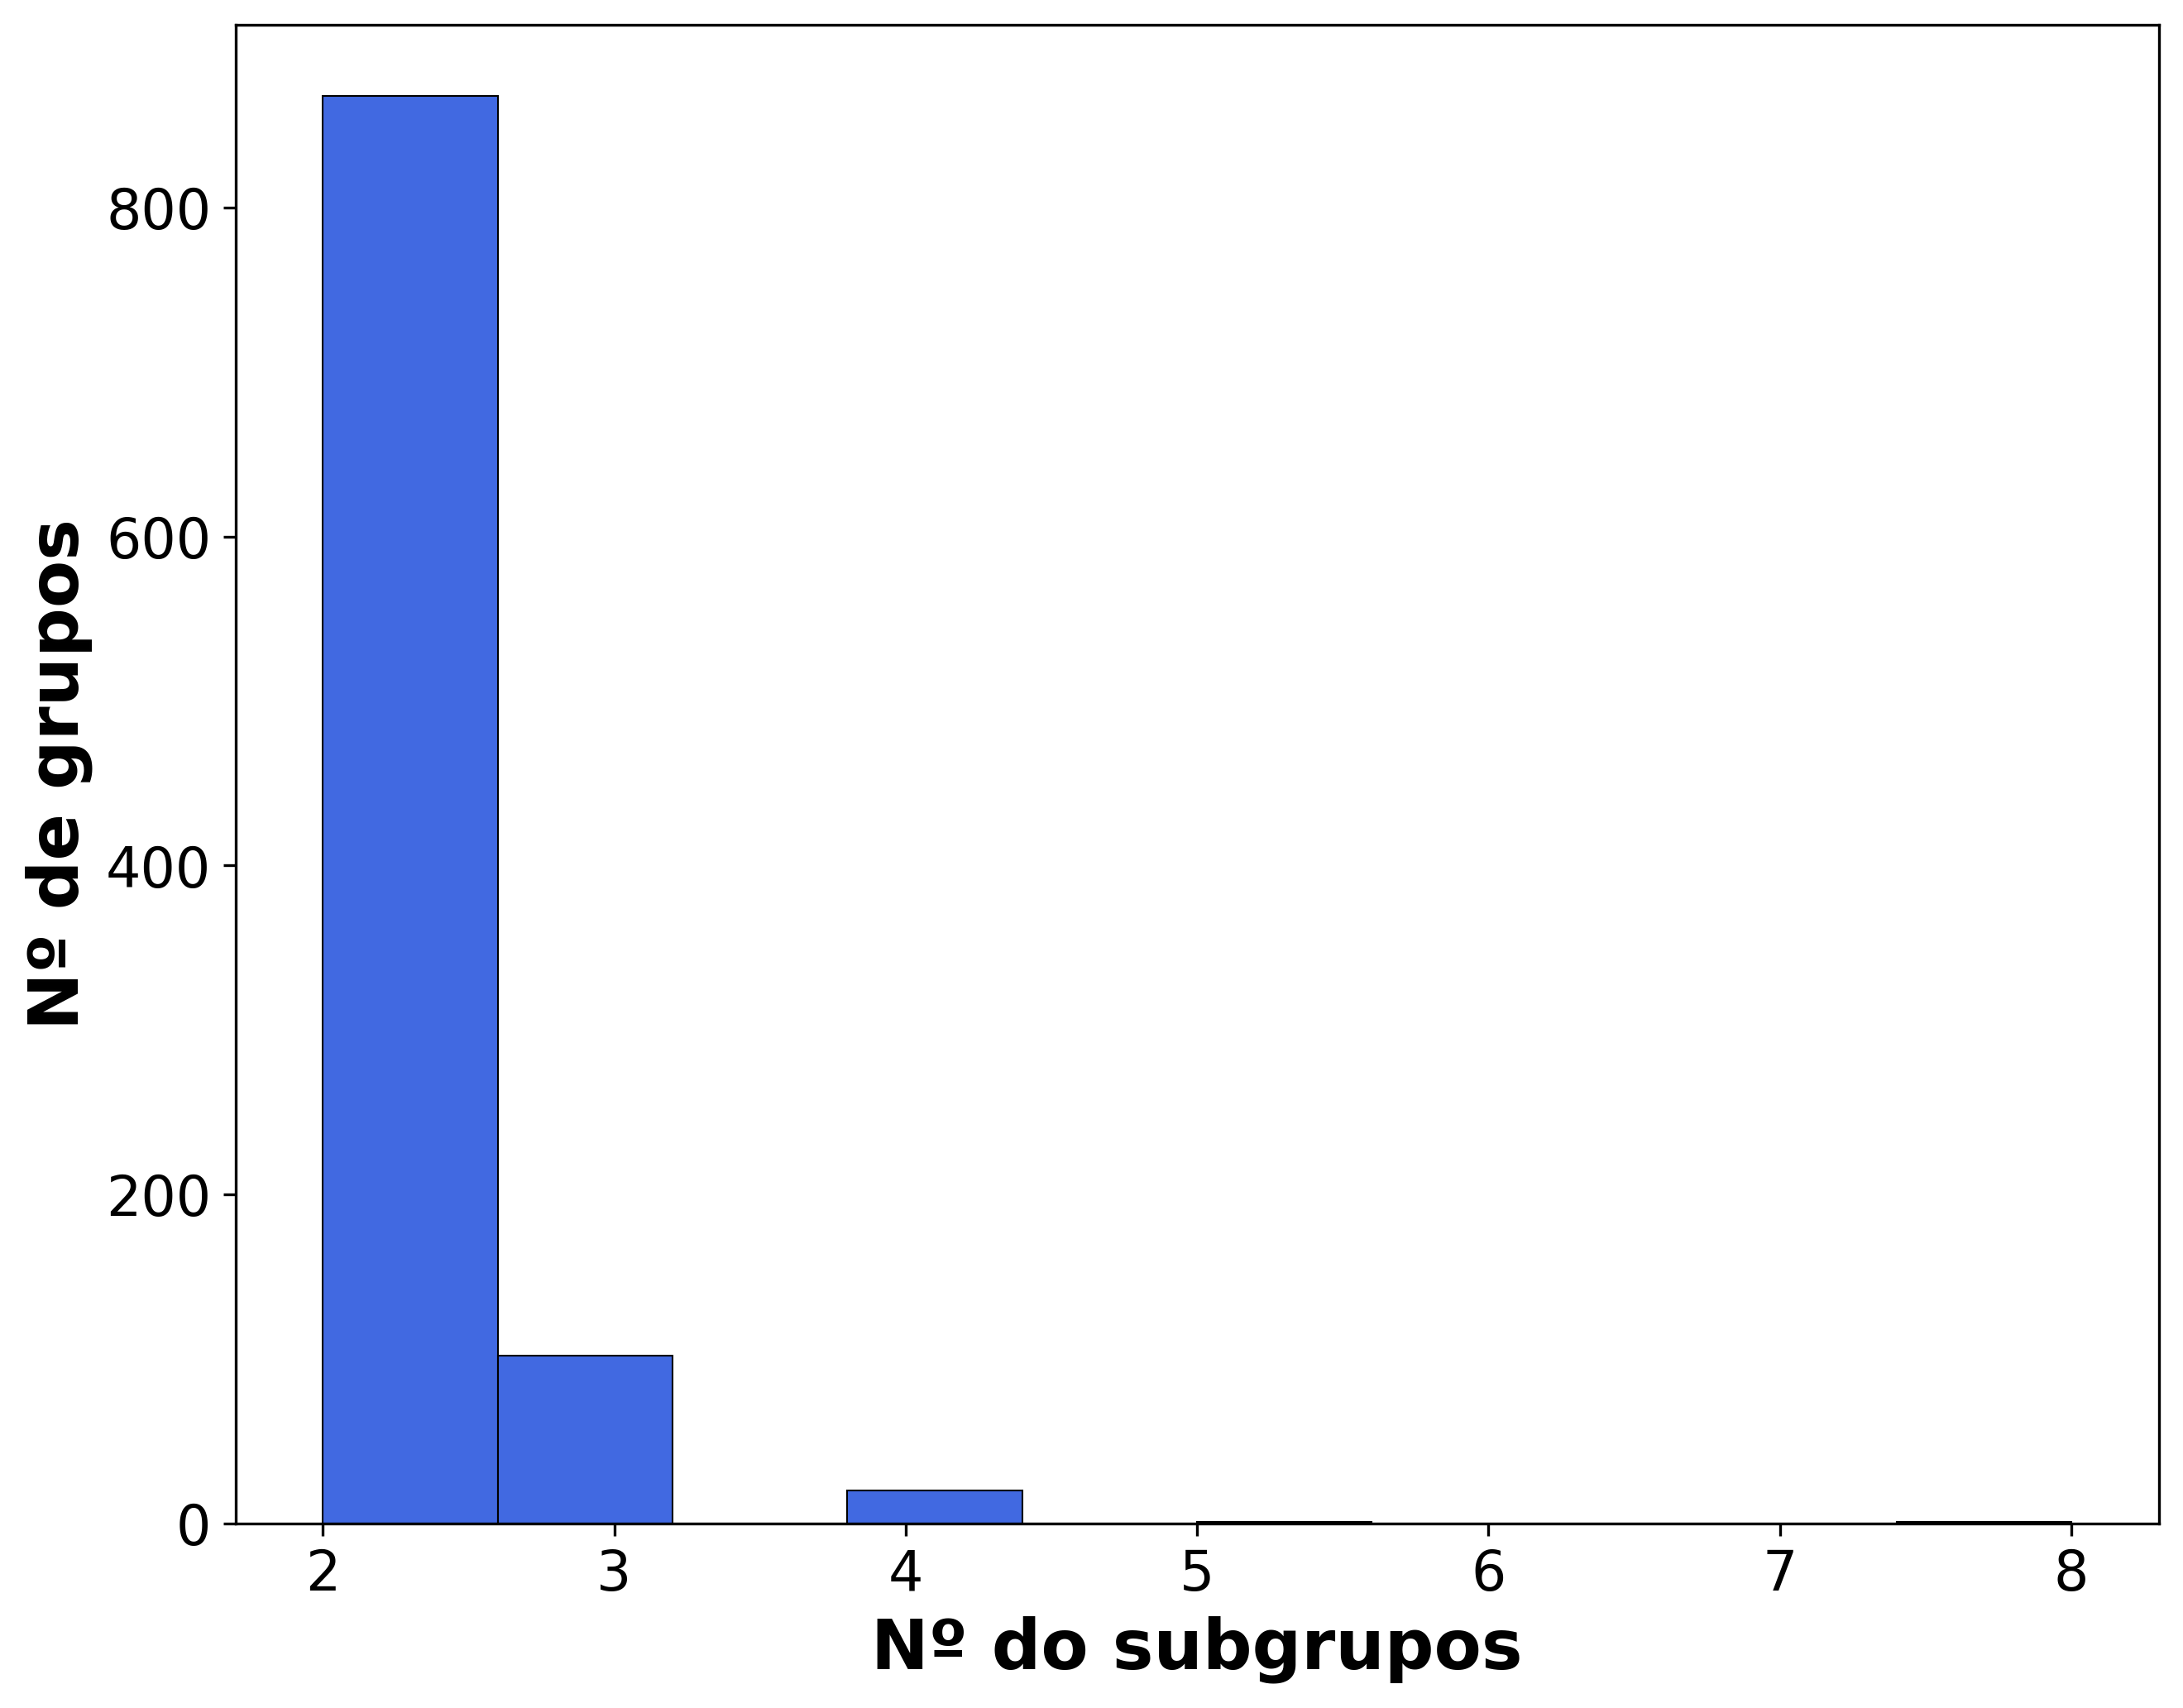

<Figure size 1800x1200 with 0 Axes>

In [88]:
plot_histogram(num_subgroups, 10, 'Nº do subgrupos', 'Nº de grupos', log=False)

### Number of items after regrouping step

In [113]:
num_items = []

for key, info in groups_.items():
    subgroups = info['groups']
    if len(subgroups) <= 1:
        continue
    size = 0
    for group in subgroups:
        size += len(groups_items[group])
    num_items.append(size)

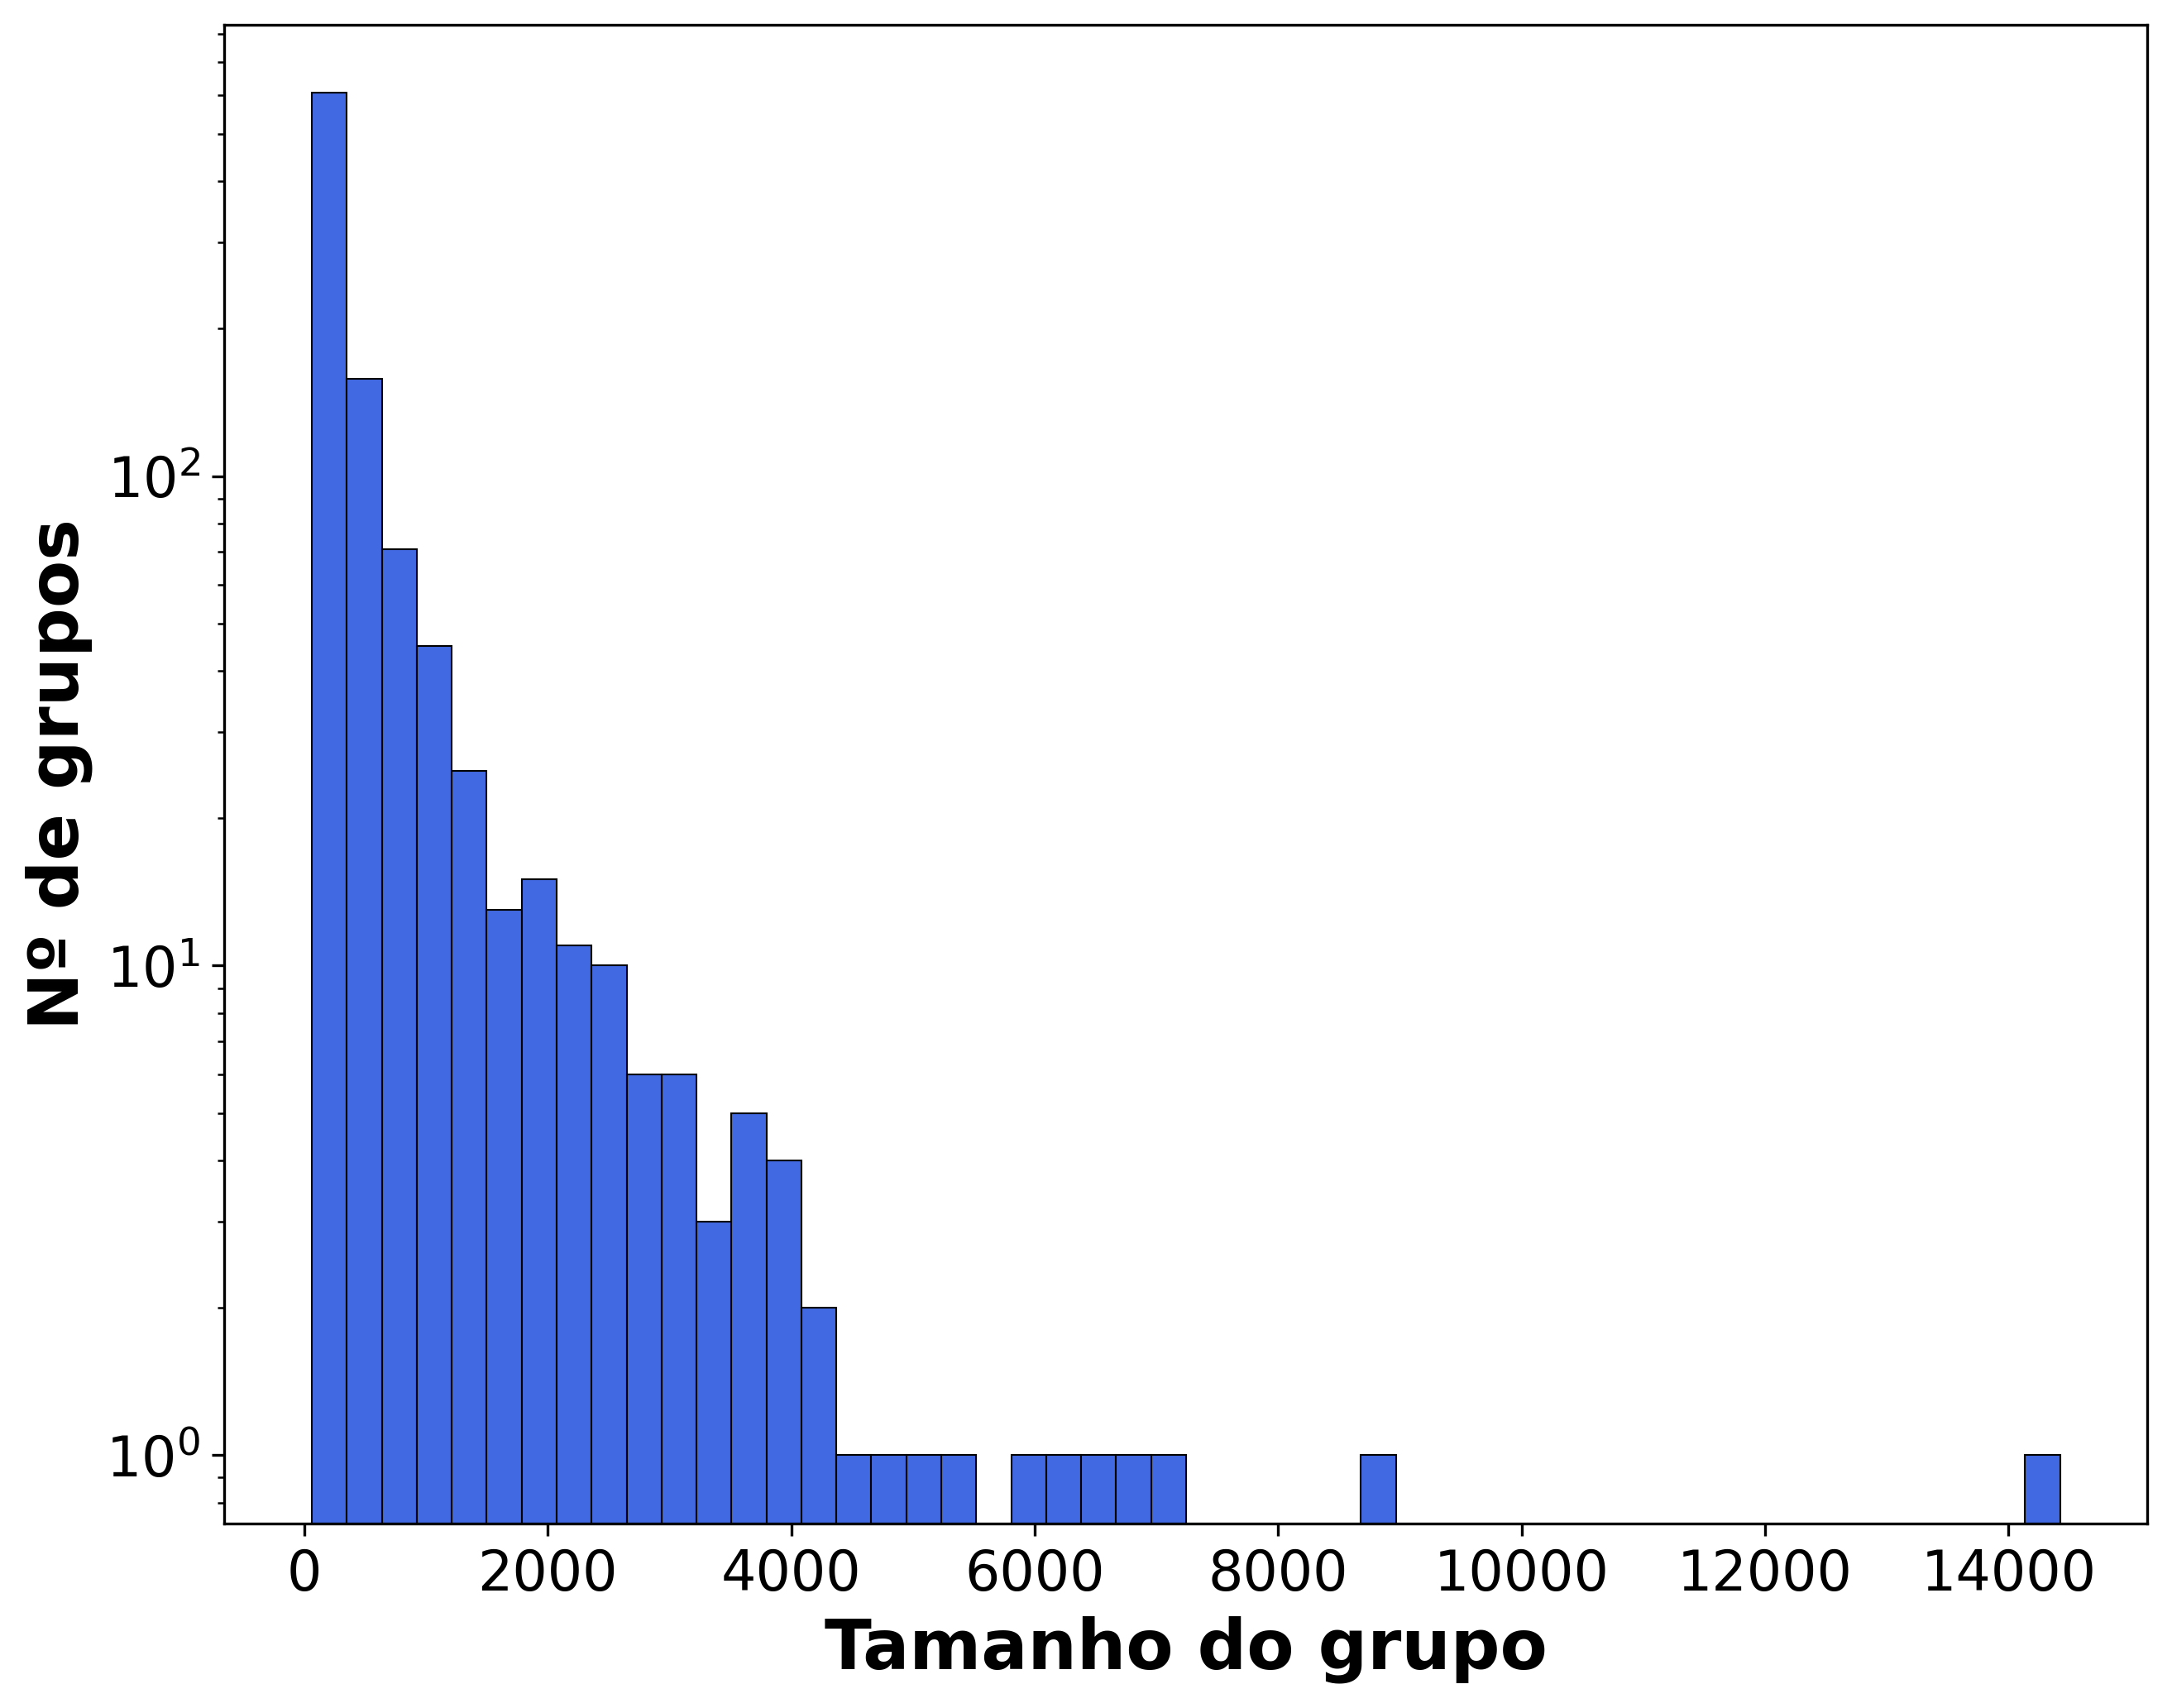

<Figure size 1800x1200 with 0 Axes>

In [114]:
plot_histogram(num_items, 50, 'Tamanho do grupo', 'Nº de grupos', log=True)

## Distribuition of number and units of measure

In [142]:
groups = list(groups_.items())
groups.sort(key=lambda group: len(group[1]["groups"]), reverse=True)
groups = list(filter(lambda group: len(group[1]["groups"]) > 1, groups))

hist_unique_units_of_measure, hist_unique_numbers = Counter(), Counter()

unique_units_of_measure_list = []
unique_numbers_list = []

selected_groups_count = 0
for g in groups:
    new_group = g[0]
    canonical_description = g[1]["description"]

    if not contains_number_and_unit_of_measure(canonical_description):
        continue

    previous_groups = g[1]["groups"]
    previous_groups_with_n_items, frequent_descriptions = get_description_and_n_items(previous_groups, groups_items)
    previous_groups_str = ", ".join(previous_groups_with_n_items)

    unique_units_of_measure = get_units_of_measure(previous_groups, groups_items)
    hist_unique_units_of_measure[len(unique_units_of_measure)] += 1
    unique_units_of_measure_list.append(len(unique_units_of_measure))
    unique_units_of_measure_str = ", ".join(unique_units_of_measure)

    unique_numbers = get_numbers(previous_groups, groups_items)
    hist_unique_numbers[len(unique_numbers)] += 1
    unique_numbers_list.append(len(unique_numbers))
    unique_numbers_str = ", ".join(unique_numbers)

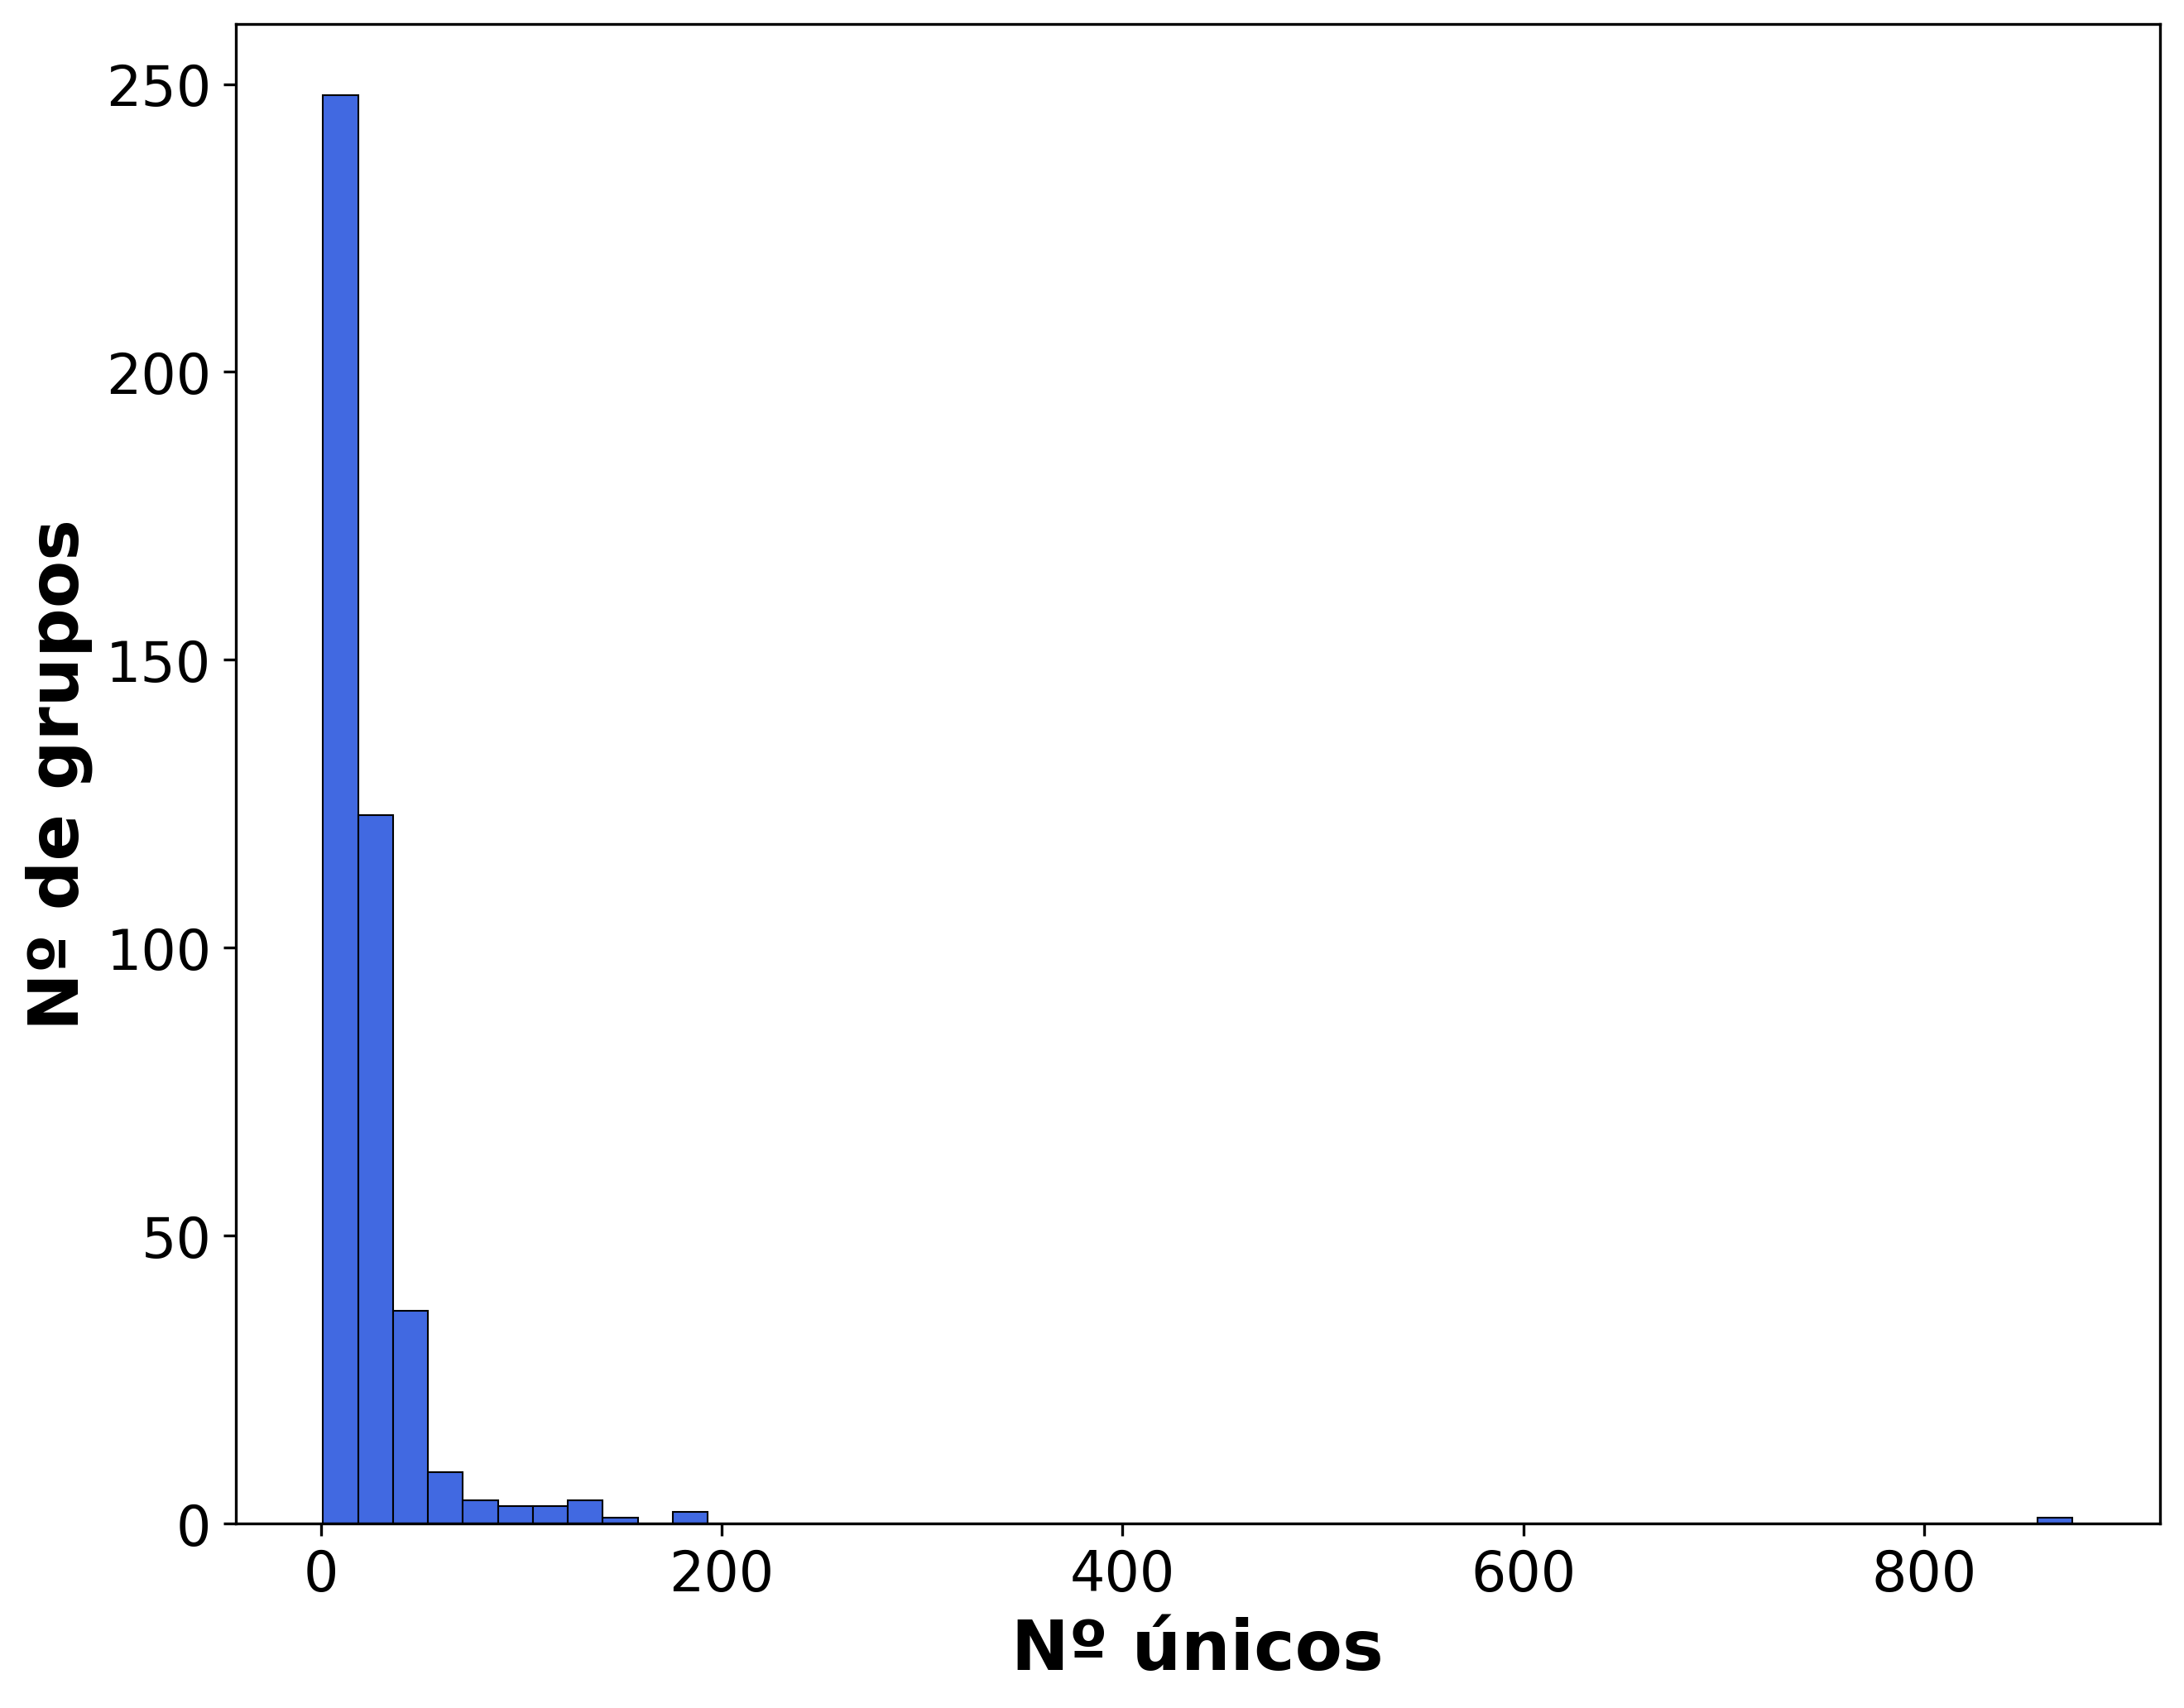

<Figure size 1800x1200 with 0 Axes>

In [143]:
plot_histogram(unique_numbers_list, 50, 'Nº únicos', 'Nº de grupos', log=False)

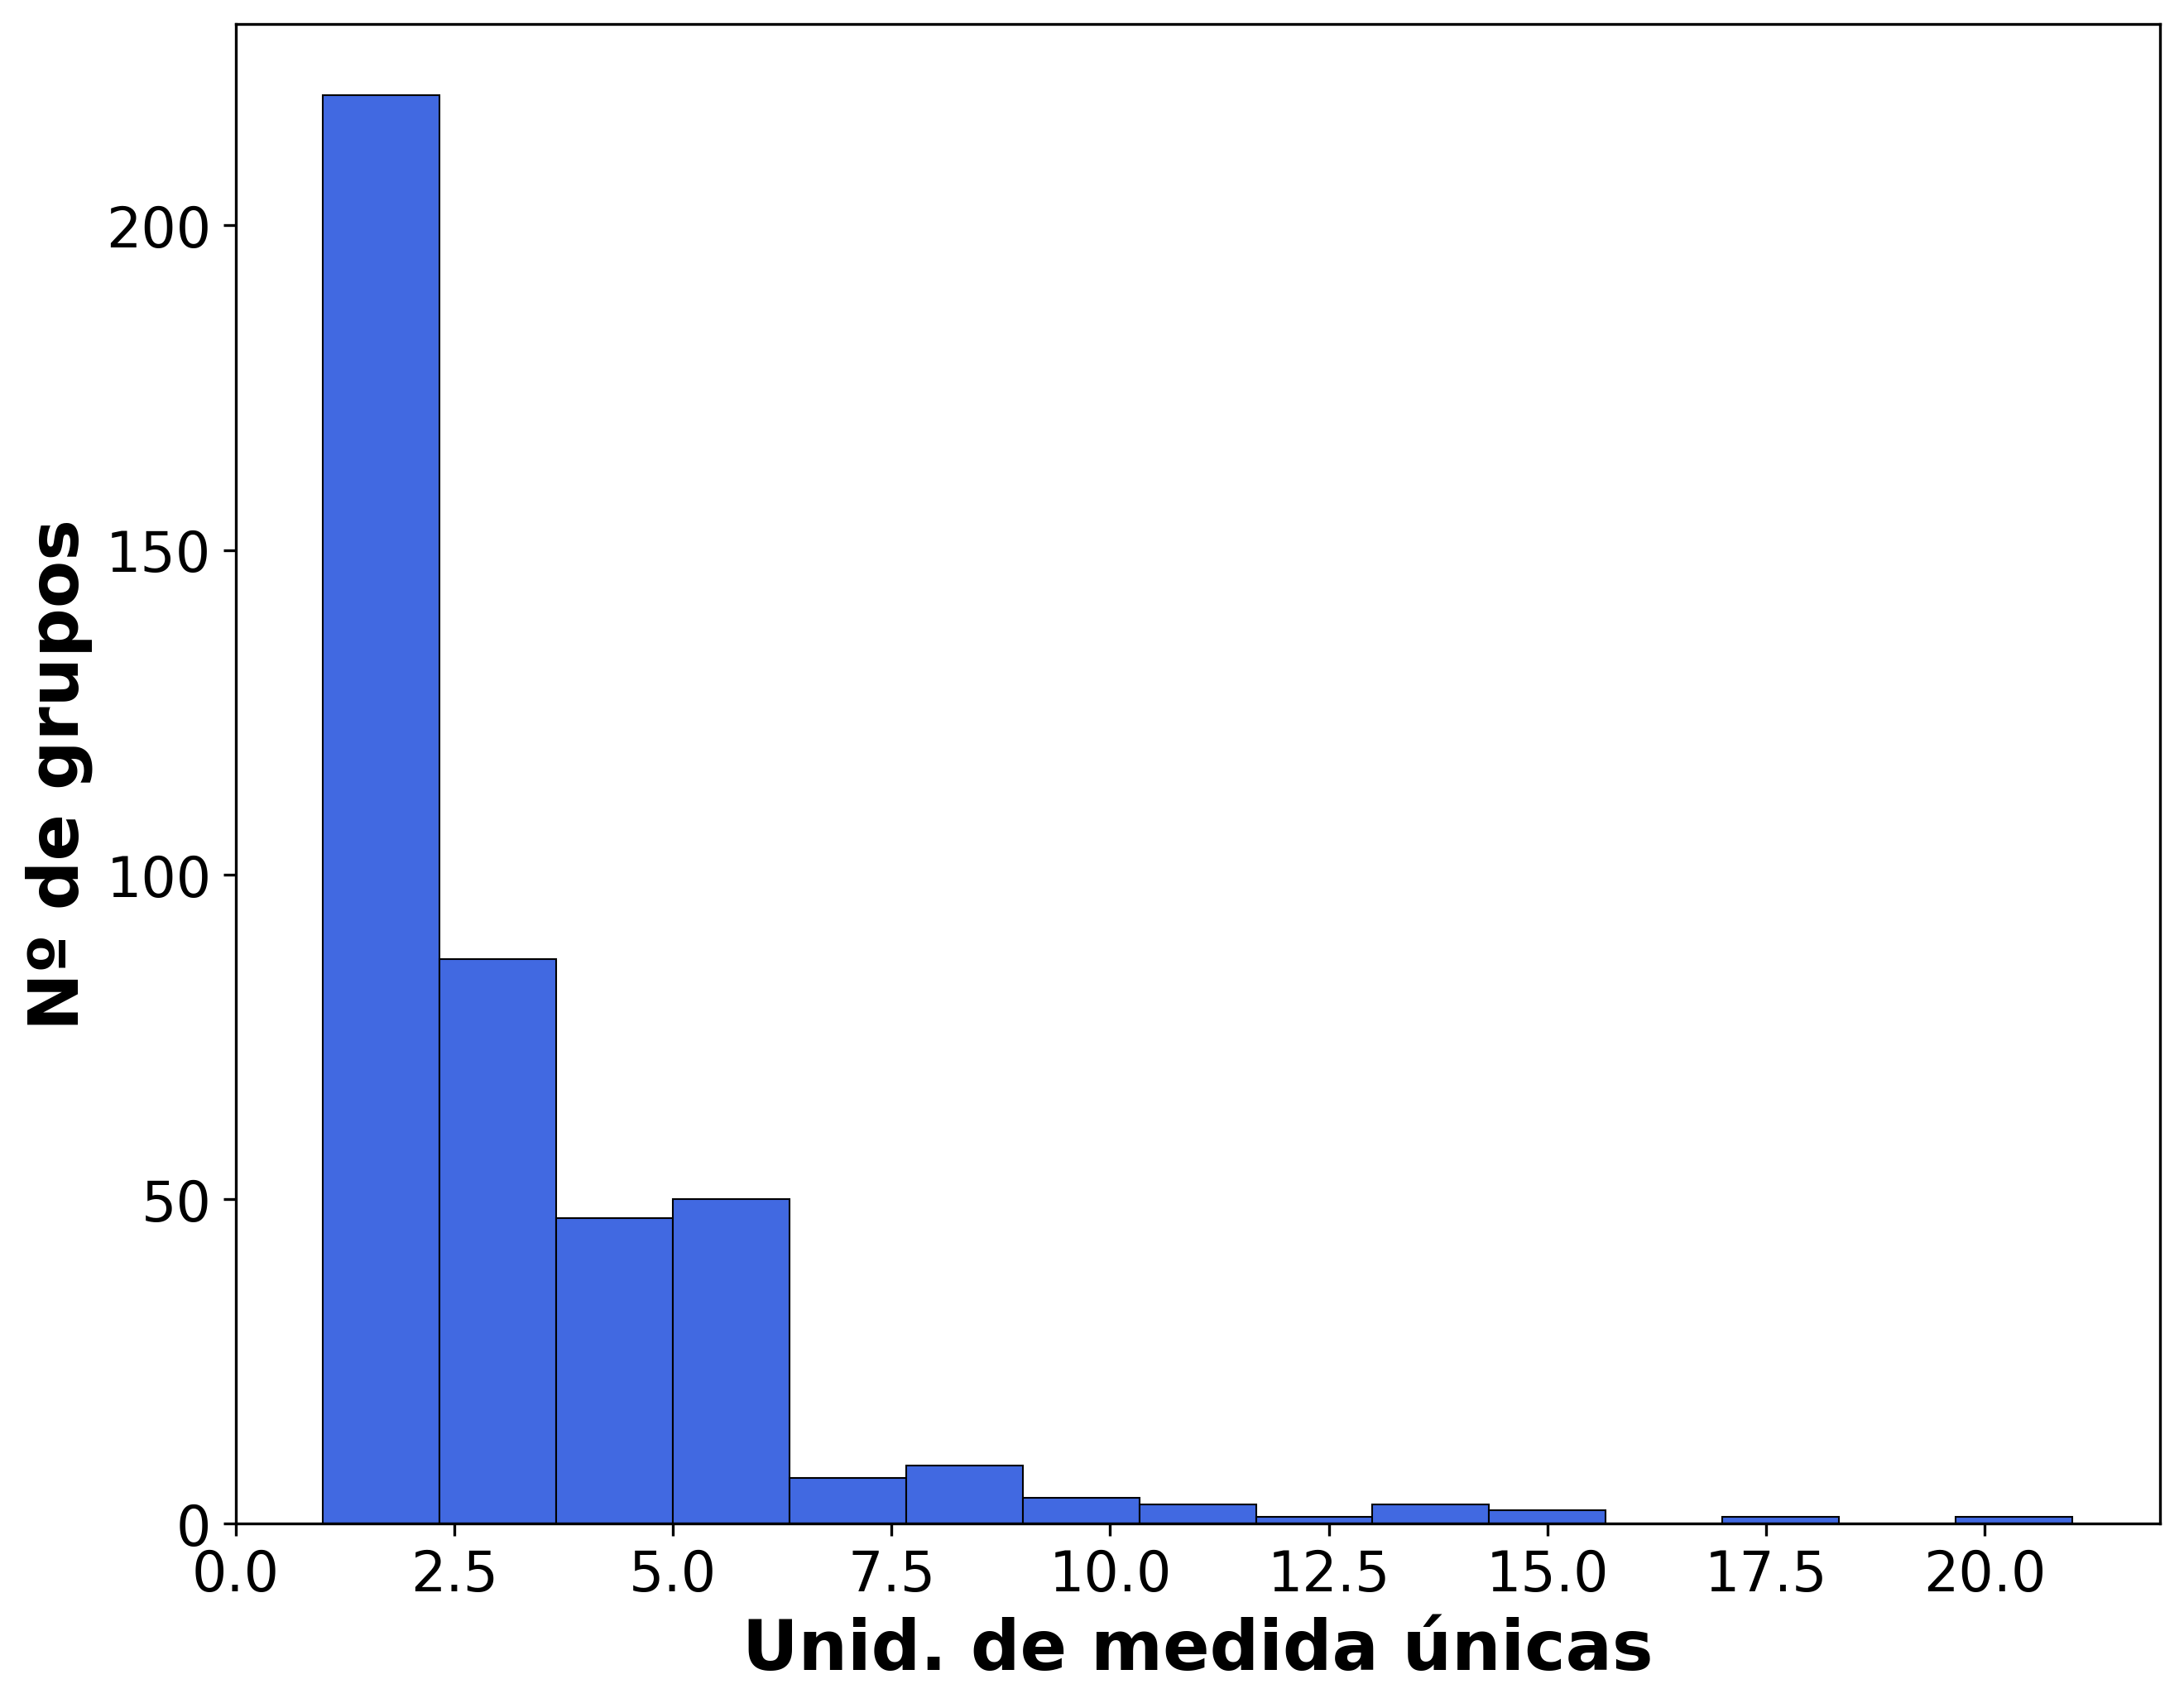

<Figure size 1800x1200 with 0 Axes>

In [144]:
plot_histogram(unique_units_of_measure_list, 15, 'Unid. de medida únicas', 'Nº de grupos', log=False)